In [1]:
import numpy as np
from scipy.stats import kurtosis, skew
from numpy import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import itertools
import math
from scipy.fftpack import *
from sklearn.tree import DecisionTreeClassifier
import scipy
import pandas as pd
import os
import csv
import pickle
from __future__ import print_function

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm

In [3]:
# Functions
def get_data(persons, if_present):
    global label
    temp_data = []
    suffix = '.csv'
    activities = ['sit', 'walk', 'lay', 'stand']
    sensors = ['accelerometer', 'gyroscope', 'magnetic']
    
    temp_df = []
    all_data = []
    for per, person in enumerate(persons):
        act_data = []
        for act, activity in enumerate(activities):
            #print(activity)
            if( if_present[per][act] == 1):
                sens_data = []
                temp_df = []
                for sensor in sensors:
                    temp_df.append(pd.read_csv('results/' + person +'/' + sensor + '-' + activity + '.csv'))
                min_len = min([len(sensor_df) for sensor_df in temp_df])
                sens_data = temp_df[0].loc[:min_len-1,:]
                for sensor_df in temp_df[1:]:
                    sens_data = pd.concat([sens_data.loc[:, :sens_data.columns[-2]], sensor_df.loc[:min_len-1, :]], axis=1)

                act_data.append(sens_data)
                
        pers_data = act_data[0]
        
        for a_data in act_data[1:]:
            pers_data = pers_data.append(a_data)
        pers_data.to_csv('results/'+ str(per) + '.csv', index=False, header=True)
        all_data.append(pers_data)    
    
    data = all_data[0]
    for a_data in all_data[1:]:
        data = data.append(a_data)
        
    data.to_csv('results/temp_file2.csv', header=True, index=False)
    
    columns = data.columns
    data.columns = [i if i== len(columns)-1 else columns[i] for i in range(len(columns))]
    label_col = len(data.columns) - 1
    
    data.to_csv('results/temp_file.csv', header=True, index=False)
    #data.columns[len(data.columns) - 1] = len(data.columns) - 1
    
    
    train_data, test_data = train_test_split(data, test_size=0.2,shuffle=True)
    
    train_labels = train_data[label_col]
    train_data = train_data.drop(label_col, axis=1)
    
    test_labels = test_data[label_col]
    test_data = test_data.drop(label_col, axis=1)
    
    labels = data[label_col]
    data = data.drop(label_col, axis=1)
    
    train_labels = train_labels.astype('int')
    test_labels = test_labels.astype('int')
    labels = labels.astype('int')
    
    return data, labels, train_data, train_labels, test_data, test_labels

def readData(label,feature):
    suffix = '.csv'
    filename = os.path.join('data/csv/',label,feature+suffix)
    dataframe = pd.read_csv(filename,header=None)
    dataframe.columns = ['id','x','y','z','a','label']
    return dataframe

def stft(x, fftsize=256, overlap=2):   
    hop = fftsize // overlap
    w = scipy.hanning(fftsize+1)[:-1]
    return np.array([np.fft.rfft(w*x[i:i+fftsize]) for i in range(0, len(x)-fftsize, hop)])

def get_fft(x):   
    return np.fft.rfft(x)
    
def get_frequency(time):
    total_time = time[-1] - time[0]
    total_samples = len(time)
    frequency = (total_samples * 1000) // total_time
    return frequency

def basicFeats(x, fftsize=256, overlap=2):
    meanamp = []
    maxamp = []
    minamp = []
    stdamp = []
    mad=[]
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        meanamp.append(np.array(np.mean(x[i:i+fftsize])))
        maxamp.append(np.array(np.max(x[i:i+fftsize])))
        minamp.append(np.array(np.min(x[i:i+fftsize])))
        stdamp.append(np.array(np.std(x[i:i+fftsize])))
        mad.append(np.array(np.median(np.abs(x[i:i+fftsize] - np.median(x[i:i+fftsize])))))
    return meanamp, maxamp, minamp, stdamp, mad

def feature(x, y, z, m, fftsize=256, overlap=2):
    energyamp_m = []
    kurtosisamp_m = []
    skewamp_m = []
    meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x = basicFeats(x, fftsize)
    meanamp_y, maxamp_y, minamp_y, stdamp_y, mad_y = basicFeats(y, fftsize)
    meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z = basicFeats(z, fftsize)
    meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m = basicFeats(m, fftsize)
    
    hop = fftsize // overlap
    for i in range(0, len(m)-fftsize, hop):
        energyamp_m.append(np.array(np.sum(np.power(m[i:i+fftsize],2))))
        kurtosisamp_m.append(kurtosis(m[i:i+fftsize]))
        skewamp_m.append(skew(m[i:i+fftsize]))
                
    return meanamp_x, maxamp_x, minamp_x, stdamp_x,mad_x, meanamp_y, maxamp_y, minamp_y, stdamp_y,mad_y, \
        meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z,meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m,\
    energyamp_m,kurtosisamp_m,skewamp_m

def normalize_fft_feat(meanamp_x, maxamp_x, minamp_x, stdamp_x,mad_x, meanamp_y, maxamp_y, minamp_y, 
                       stdamp_y,mad_y,meanamp_z, maxamp_z, minamp_z, stdamp_z,mad_z,meanamp_m, maxamp_m, minamp_m, 
                       stdamp_m,mad_m,energyamp_m,kurtosisamp_m,skewamp_m):
    valmean_nor_x = meanamp_x / np.linalg.norm(meanamp_x)
    valmax_nor_x = maxamp_x / np.linalg.norm(maxamp_x)
    valmin_nor_x = minamp_x / np.linalg.norm(minamp_x)
    valstd_nor_x = stdamp_x / np.linalg.norm(stdamp_x)
    mad_nor_x = mad_x / np.linalg.norm(mad_x)
    
    valmean_nor_y = meanamp_x / np.linalg.norm(meanamp_y)
    valmax_nor_y = maxamp_x / np.linalg.norm(maxamp_y)
    valmin_nor_y = minamp_x / np.linalg.norm(minamp_y)
    valstd_nor_y = stdamp_x / np.linalg.norm(stdamp_y)
    mad_nor_y = mad_y / np.linalg.norm(mad_y)
    
    valmean_nor_z = meanamp_x / np.linalg.norm(meanamp_z)
    valmax_nor_z = maxamp_x / np.linalg.norm(maxamp_z)
    valmin_nor_z = minamp_x / np.linalg.norm(minamp_z)
    valstd_nor_z = stdamp_x / np.linalg.norm(stdamp_z)
    mad_nor_z = mad_z / np.linalg.norm(mad_z)
    
    valmean_nor_m = meanamp_x / np.linalg.norm(meanamp_m)
    valmax_nor_m = maxamp_x / np.linalg.norm(maxamp_m)
    valmin_nor_m = minamp_x / np.linalg.norm(minamp_m)
    valstd_nor_m = stdamp_x / np.linalg.norm(stdamp_m)
    mad_nor_m = mad_m / np.linalg.norm(mad_m)
    
    energyamp_nor_m = energyamp_m / np.linalg.norm(energyamp_m)
    kurtosisamp_nor_m = kurtosisamp_m / np.linalg.norm(kurtosisamp_m)
    skewamp_nor_m = skewamp_m / np.linalg.norm(skewamp_m)

    
    return valmean_nor_x, valmax_nor_x, valmin_nor_x, valstd_nor_x, mad_nor_x, valmean_nor_y, valmax_nor_y, valmin_nor_y, valstd_nor_y,mad_nor_y, \
            valmean_nor_z, valmax_nor_z, valmin_nor_z, valstd_nor_z,mad_nor_z,valmean_nor_m, valmax_nor_m, valmin_nor_m, valstd_nor_m,mad_nor_m,\
    energyamp_nor_m,kurtosisamp_nor_m,skewamp_nor_m
    
def normalize_feat(meanamp_x, maxamp_x, minamp_x, stdamp_x,mad_x, meanamp_y, maxamp_y, minamp_y, stdamp_y,mad_y,
                   meanamp_z, maxamp_z, minamp_z, stdamp_z,mad_z, meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m,
                   energyamp_m, kurtosisamp_m,skewamp_m,energy_signal, diff_x, diff_y, diff_z, 
                   diff_m,iqr_x,iqr_y,iqr_z,smaq):
    valmean_nor_x = meanamp_x / np.linalg.norm(meanamp_x)
    valmax_nor_x = maxamp_x / np.linalg.norm(maxamp_x)
    valmin_nor_x = minamp_x / np.linalg.norm(minamp_x)
    valstd_nor_x = stdamp_x / np.linalg.norm(stdamp_x)
    mad_nor_x = mad_x / np.linalg.norm(mad_x)
    
    valmean_nor_y = meanamp_x / np.linalg.norm(meanamp_y)
    valmax_nor_y = maxamp_x / np.linalg.norm(maxamp_y)
    valmin_nor_y = minamp_x / np.linalg.norm(minamp_y)
    valstd_nor_y = stdamp_x / np.linalg.norm(stdamp_y)
    mad_nor_y = mad_y / np.linalg.norm(mad_y)
    
    valmean_nor_z = meanamp_x / np.linalg.norm(meanamp_z)
    valmax_nor_z = maxamp_x / np.linalg.norm(maxamp_z)
    valmin_nor_z = minamp_x / np.linalg.norm(minamp_z)
    valstd_nor_z = stdamp_x / np.linalg.norm(stdamp_z)
    mad_nor_z = mad_z / np.linalg.norm(mad_z)
    
    valmean_nor_m = meanamp_x / np.linalg.norm(meanamp_m)
    valmax_nor_m = maxamp_x / np.linalg.norm(maxamp_m)
    valmin_nor_m = minamp_x / np.linalg.norm(minamp_m)
    valstd_nor_m = stdamp_x / np.linalg.norm(stdamp_m)
    mad_nor_m = mad_m / np.linalg.norm(mad_m)
    
    valenergy_nor = energyamp_m / np.linalg.norm(energyamp_m)
    kurtosisamp_nor_m = kurtosisamp_m / np.linalg.norm(kurtosisamp_m)
    skewamp_nor_m = skewamp_m / np.linalg.norm(skewamp_m)   
    energy_signal_nor = energy_signal / np.linalg.norm(energy_signal)
    
    nor_diff_x = diff_x / np.linalg.norm(diff_x)
    nor_diff_y = diff_y / np.linalg.norm(diff_y)
    nor_diff_z = diff_z / np.linalg.norm(diff_z)
    nor_diff_m = diff_m / np.linalg.norm(diff_m)
    
    nor_iqr_x=iqr_x / np.linalg.norm(iqr_x)
    nor_iqr_y=iqr_y / np.linalg.norm(iqr_y)
    nor_iqr_z=iqr_z / np.linalg.norm(iqr_z)
    nor_sma=smaq / np.linalg.norm(smaq)
    
    return valmean_nor_x, valmax_nor_x, valmin_nor_x, valstd_nor_x, mad_nor_x,valmean_nor_y, valmax_nor_y, valmin_nor_y, valstd_nor_y,mad_nor_y, \
            valmean_nor_z, valmax_nor_z, valmin_nor_z, valstd_nor_z, mad_nor_z,valmean_nor_m, valmax_nor_m, valmin_nor_m, valstd_nor_m, mad_nor_m,\
            valenergy_nor, kurtosisamp_nor_m, skewamp_nor_m,energy_signal_nor, nor_diff_x, nor_diff_y, nor_diff_z, nor_diff_m,nor_iqr_x,nor_iqr_y,nor_iqr_z,nor_sma

In [9]:
#global dict
label = {'sitting' : 0, 'walking' : 1, 'laying_down' : 2, 'standing' : 3}

def inter_quartile_range(x, y, z, fftsize=256, overlap=2):
    """Calculates inter-quartile range"""
    iqr_x = []
    iqr_y = []
    iqr_z = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        iqr_x.append(np.subtract(*np.percentile(x[i:i+fftsize], [75, 25])))
        iqr_y.append(np.subtract(*np.percentile(y[i:i+fftsize], [75, 25])))
        iqr_z.append(np.subtract(*np.percentile(z[i:i+fftsize], [75, 25])))
    return iqr_x, iqr_y, iqr_z

def sma(x, y, z, fftsize=256, overlap=2):
    """Calculates signal magnitude area"""
    abs_x = []
    abs_y = []
    abs_z = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        abs_x.append(np.absolute(x[i:i+fftsize]))
        abs_y.append(np.absolute(y[i:i+fftsize]))
        abs_z.append(np.absolute(z[i:i+fftsize]))
    return [np.mean(x+y+z) for x,y,z in zip(abs_x, abs_y, abs_z)]

def compute_feats(*dataframes, show_plots=False):
    show_plots=False
    global label
    df = pd.DataFrame(columns=list(range(47)))
    label_col = len(df.columns) - 1
    for counter, data in enumerate(dataframes):
        #Other features
        time, x, y, z, _, str_label = np.array(data[0]), np.array(data[1]), np.array(data[2]), np.array(data[3]), np.array(data[4]), np.array(data[5])        
        mpre = x*x+y*y+z*z
        freq = get_frequency(time)
        window_size = 3*freq #3 seconds time frame
        m = np.sqrt(mpre)
        m_smooth = np.zeros(len(m))
        m_smooth = m;
        for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
            m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] +m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
        m = m_smooth

        if show_plots:
            plt.plot(m[:4000])
            plt.title('Accelerometer Data - '+str_label[0])
            plt.ylabel('Amplitude')
            plt.xlabel('Time')
            plt.show()

        #FFT features
        stft_signal = stft(m,fftsize=window_size)
        energy_signal = []

        for i, amp in enumerate(stft_signal):
            energy_signal.append(np.sum(np.power(abs(stft_signal[i]),2)))
    
        ft_x=get_fft(x)
        ft_x = np.abs(ft_x)
        ft_y=get_fft(y)
        ft_y = np.abs(ft_y)
        ft_z=get_fft(z)
        ft_z = np.abs(ft_z)
        
        mpre = ft_x*ft_x+ft_y*ft_y+ft_z*ft_z
        m_f = np.sqrt(mpre)
        m_smooth = np.zeros(len(m_f))
        m_smooth = m_f;

        for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
            m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] +m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
        
        m_f = m_smooth
     
        meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x,meanamp_y, maxamp_y, minamp_y, stdamp_y,mad_y,\
        meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z,meanamp_m, maxamp_m, minamp_m, stdamp_m,mad_m,\
        energyamp_m,kurtosisamp_m,skewamp_m = feature(ft_x,ft_y,ft_z,m_f,fftsize=window_size)
        
        #Normalize fft features
        valmean_nor_ft_x, valmax_nor_ft_x, valmin_nor_ft_x, valstd_nor_ft_x, mad_nor_ft_x, \
        valmean_nor_ft_y, valmax_nor_ft_y, valmin_nor_ft_y, valstd_nor_ft_y, mad_nor_ft_y,\
        valmean_nor_ft_z, valmax_nor_ft_z, valmin_nor_ft_z, valstd_nor_ft_z, mad_nor_ft_z,\
        valmean_nor_ft_m, valmax_nor_ft_m, valmin_nor_ft_m, valstd_nor_ft_m, mad_nor_ft_m,\
        energyamp_nor_ft_m,kurtosisamp_nor_ft_m,skewamp_nor_ft_m=normalize_fft_feat(meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x,meanamp_y, maxamp_y, minamp_y, stdamp_y,mad_y,meanamp_z, maxamp_z, minamp_z, stdamp_z,mad_z,meanamp_m, maxamp_m, minamp_m, stdamp_m,mad_m,energyamp_m,kurtosisamp_m,skewamp_m)
        
        
        #Other features
        meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x,meanamp_y, maxamp_y, minamp_y, stdamp_y, mad_y,\
        meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z,meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m,\
        energyamp_m,kurtosisamp_m,skewamp_m = feature(x, y, z, m,fftsize=window_size)
        diff_x = np.subtract(maxamp_x, minamp_x)
        diff_y = np.subtract(maxamp_y, minamp_y)
        diff_z = np.subtract(maxamp_z, minamp_z)
        diff_m = np.subtract(maxamp_m, minamp_m)
        
        iqr_x,iqr_y,iqr_z=inter_quartile_range(x,y,z, fftsize=window_size)
        smaq=sma(x,y,z, fftsize=window_size)
        
        if show_plots:
            plt.plot(energy_signal[:4000])
            plt.xlabel('Freq')
            plt.ylabel('Energy')
            plt.title('Frequency vs Energy - '+str_label[0])
            plt.show()
        
        # Normalize other features
        valmean_nor_x, valmax_nor_x, valmin_nor_x, valstd_nor_x, mad_nor_x,\
        valmean_nor_y, valmax_nor_y, valmin_nor_y, valstd_nor_y, mad_nor_y,\
        valmean_nor_z, valmax_nor_z, valmin_nor_z, valstd_nor_z, mad_nor_z,\
        valmean_nor_m, valmax_nor_m, valmin_nor_m, valstd_nor_m, mad_nor_m,\
        valenergy_nor, kurtosisamp_nor_m,skewamp_nor_m,energy_signal_nor, \
        nor_diff_x, nor_diff_y, nor_diff_z, nor_diff_m, nor_iqr_x,nor_iqr_y,nor_iqr_z,nor_sma = normalize_feat(meanamp_x, maxamp_x, minamp_x, stdamp_x,mad_x, 
                                                                                                          meanamp_y, maxamp_y, minamp_y, stdamp_y,mad_y,
                                                                                                          meanamp_z, maxamp_z, minamp_z, stdamp_z,mad_z,
                                                                                                          meanamp_m, maxamp_m, minamp_m, stdamp_m,mad_m,
                                                                                                          energyamp_m,kurtosisamp_m,skewamp_m, energy_signal, diff_x, diff_y,
                                                                                                          diff_z, diff_m,iqr_x,iqr_y,iqr_z,smaq)
        
        
        
        ####################################################################################
        ## Save the extracted features.
        #with open('results/' + str_label[0] +'.csv','wb') as fp:
        #    writer = csv.writer(fp)
        #    for i in range(len(valmean)):
        #        writer.writerow([valmean[i],valmax[i],valmin[i],valstd[i],valenergy[i],energy_signal[i],label[str_label[0]]])
        
        temp_df = pd.DataFrame.from_records(list(zip(valmean_nor_x, valmax_nor_x, valmin_nor_x, valstd_nor_x,mad_nor_x,
                                                     valmean_nor_y, valmax_nor_y, valmin_nor_y, valstd_nor_y,mad_nor_y,
                                                     valmean_nor_z, valmax_nor_z, valmin_nor_z, valstd_nor_z,mad_nor_z,
                                                     valmean_nor_m, valmax_nor_m, valmin_nor_m, valstd_nor_m,mad_nor_m,
                                                     valenergy_nor,energy_signal_nor,
                                                     nor_diff_x, nor_diff_y, nor_diff_z, nor_diff_m,
                                                     nor_iqr_x,nor_iqr_y,nor_iqr_z,nor_sma,
                                                     valmean_nor_ft_x, valmax_nor_ft_x,valmin_nor_ft_x, valstd_nor_ft_x,
                                                     valmean_nor_ft_y, valmax_nor_ft_y, valmin_nor_ft_y, valstd_nor_ft_y,
                                                     valmean_nor_ft_z, valmax_nor_ft_z, valmin_nor_ft_z, valstd_nor_ft_z,
                                                    valmean_nor_ft_m, valmax_nor_ft_m, valmin_nor_ft_m, valstd_nor_ft_m,
                                                    energyamp_nor_ft_m)))
        temp_df[label_col] = label[str_label[0]]
       
        df = df.append(temp_df)
        
    return df

In [10]:
persons = ['ayush', 'shrey', 'varun']
activities = ['sit', 'walk', 'lay', 'stand']
sensors = ['accelerometer', 'gyroscope', 'magnetic']
if_present = [[1,1,0,0], [1,0,1,0], [1,0,0,1]]
temp_df = []
for per, person in enumerate(persons):
    for act, activity in enumerate(activities):
        for sensor in sensors:
            if( if_present[per][act] == 1):
                print(person+" "+activity+" "+sensor)
                df =  pd.read_csv('Data/csv/' + person +'/' + sensor + '-' + activity + '.csv', header=None)
                df = compute_feats(df, show_plots=True)
                df.columns = [sensor[:3] + '_' + str(col) for col in df.columns]
                df.to_csv('results/' + person +'/' + sensor + '-'  + activity + '.csv', header=True, index=False)

ayush sit accelerometer
ayush sit gyroscope
ayush sit magnetic
ayush walk accelerometer
ayush walk gyroscope
ayush walk magnetic
shrey sit accelerometer
shrey sit gyroscope
shrey sit magnetic
shrey lay accelerometer
shrey lay gyroscope
shrey lay magnetic
varun sit accelerometer
varun sit gyroscope
varun sit magnetic
varun stand accelerometer
varun stand gyroscope
varun stand magnetic


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [12]:
###################################### Random Forest CLASSIFIER #####################################
def RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',search_best_params=False, load_model=True):
    if search_best_params:
        param_grid = { 
            'n_estimators': [200, 700],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        CV_clf.fit(data, labels)
        print(CV_clf.best_params_)
        print('Most important Features are:', clf.feature_importances_, sep='')
    else:
        if load_model:
            clf = pickle.load(open('models/RFClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            else:
                clf = OneVsRestClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/RFClassifier-' + use_model + '.pkl', 'wb'))

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf
    
###################################### SVM CLASSIFIER #####################################
def SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',search_best_params=False, load_model=True):
    if search_best_params:
        clf = svm.SVC()
        parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10, 100]}
        clf = GridSearchCV(clf, parameters)
        clf.fit(data, labels) 
        print(clf.best_params_)
    else:
        if load_model:
            clf = pickle.load(open('models/SVMClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(svm.SVC(C=10, kernel='rbf'))

            else:
                clf = OneVsRestClassifier(svm.SVC(C=10, kernel='rbf'))
            
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/SVMClassifier-' + use_model + '.pkl', 'wb'))

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf

###################################### DT CLASSIFIER #####################################
def DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',search_best_params=True, load_model=True):
    if search_best_params:
        clf = DecisionTreeClassifier(random_state=0)
        param_grid = { 
            'n_estimators': [200, 700],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        CV_clf.fit(data, labels)
        print(CV_clf.best_params_)
        print('Most important Features are:', clf.feature_importances_, sep='')
    else:
        if load_model:
            clf = pickle.load(open('models/RFClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            else:
                clf = OneVsRestClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/RFClassifier-' + use_model + '.pkl', 'wb'))

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf

--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       224
    walking       1.00      1.00      1.00        47
laying_down       1.00      1.00      1.00        85
   standing       1.00      1.00      1.00       137

avg / total       1.00      1.00      1.00       493

Confusion Matrix
 [[224   0   0   0]
 [  0  47   0   0]
 [  0   0  85   0]
 [  0   0   0 137]]


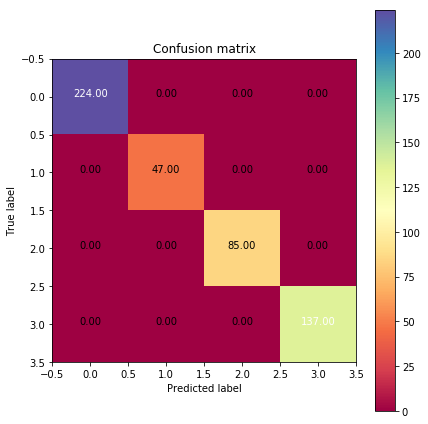

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       224
    walking       1.00      1.00      1.00        47
laying_down       1.00      1.00      1.00        85
   standing       1.00      1.00      1.00       137

avg / total       1.00      1.00      1.00       493

Confusion Matrix
 [[224   0   0   0]
 [  0  47   0   0]
 [  0   0  85   0]
 [  0   0   0 137]]


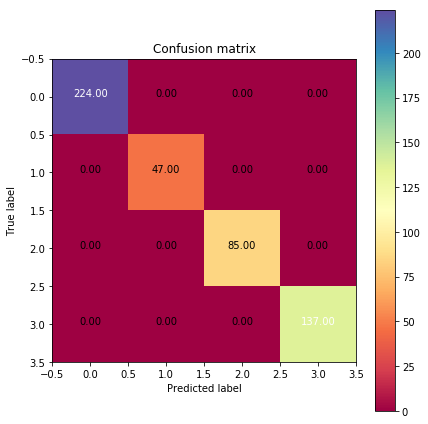

--------------------------------------------------


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [13]:
############## Random Forest Classifier ##############
search_best_params = False
load_model = False
persons = ['ayush', 'shrey', 'varun']
if_present = [[1,1,0,0], [1,0,1,0], [1,0,0,1]]

target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=False, load_model=load_model)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=False, load_model=load_model)

--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.7512953367875648
Classification Report:
              precision    recall  f1-score   support

    sitting       0.56      0.96      0.71       117
    walking       1.00      1.00      1.00        47
laying_down       1.00      0.02      0.04        93
   standing       0.94      1.00      0.97       129

avg / total       0.85      0.75      0.67       386

Confusion Matrix
 [[112   0   0   5]
 [  0  47   0   0]
 [ 88   0   2   3]
 [  0   0   0 129]]


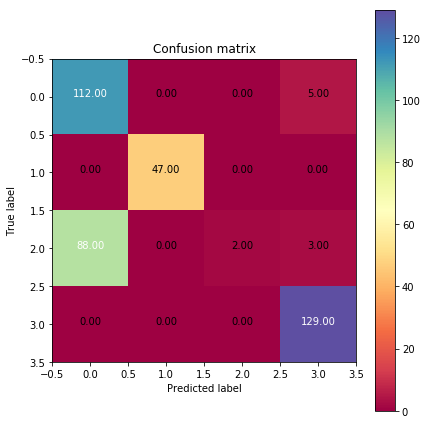

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.8652849740932642
Classification Report:
              precision    recall  f1-score   support

    sitting       0.83      0.79      0.81       117
    walking       1.00      1.00      1.00        47
laying_down       0.96      0.70      0.81        93
   standing       0.81      1.00      0.90       129

avg / total       0.87      0.87      0.86       386

Confusion Matrix
 [[ 93   0   3  21]
 [  0  47   0   0]
 [ 19   0  65   9]
 [  0   0   0 129]]


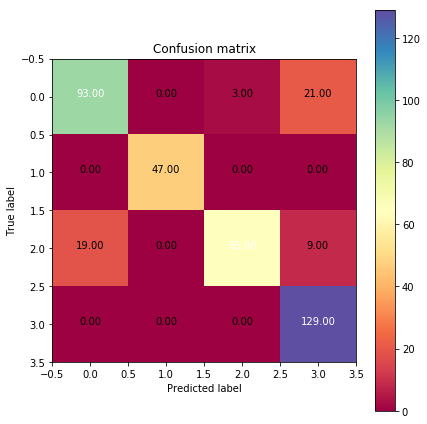

--------------------------------------------------


OneVsRestClassifier(estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [15]:
############## SVM ##############
search_best_params = False
load_model = False
persons = ['ayush', 'shrey', 'varun']
if_present = [[1,1,0,0], [1,0,1,0], [0,0,0,1]]
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=False, load_model=load_model)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=False, load_model=load_model)

In [67]:
############## Decision Tree Classifier ##############
search_best_params = True
load_model = False
persons = ['ayush', 'shrey', 'varun']

target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons)
DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=search_best_params, load_model=load_model)
DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=search_best_params, load_model=load_model)

sit
walk
lay
stand
sit
walk
lay
stand
sit
walk
lay
stand


ValueError: Invalid parameter n_estimators for estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'). Check the list of available parameters with `estimator.get_params().keys()`.

# TEST ON ANOTHER PERSON

--------------------------------------------------
USING RFClassifier-onevsone MODEL
Accuracy is: 0.6607142857142857
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       1.00      0.66      0.80        56
laying_down       0.00      0.00      0.00         0

avg / total       1.00      0.66      0.80        56

Confusion Matrix
 [[ 0  0  0]
 [ 1 37 18]
 [ 0  0  0]]


C:\Users\ashis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 4
  .format(len(labels), len(target_names))
C:\Users\ashis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


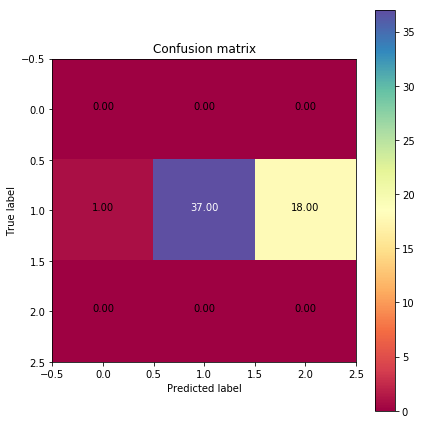

--------------------------------------------------
--------------------------------------------------
USING RFClassifier-onevsrest MODEL
Accuracy is: 0.8035714285714286
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       1.00      0.80      0.89        56
laying_down       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89        56

Confusion Matrix
 [[ 0  0  0]
 [ 4 45  7]
 [ 0  0  0]]


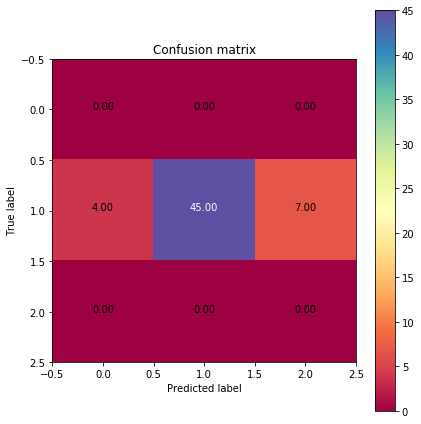

--------------------------------------------------
--------------------------------------------------
USING SVMClassifier-onevsone MODEL
Accuracy is: 0.0
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00        56
    walking       0.00      0.00      0.00         0
laying_down       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00        56

Confusion Matrix
 [[ 0  1 55]
 [ 0  0  0]
 [ 0  0  0]]


C:\Users\ashis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


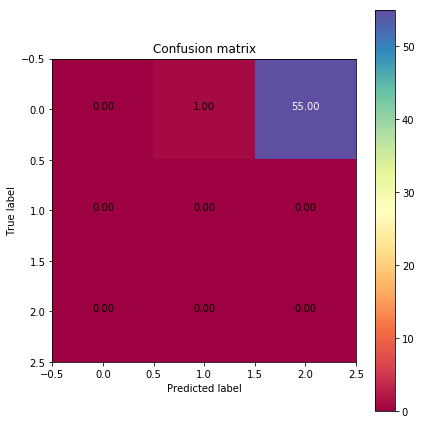

--------------------------------------------------
--------------------------------------------------
USING SVMClassifier-onevsrest MODEL
Accuracy is: 0.017857142857142856
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      0.02      0.04        56
    walking       0.00      0.00      0.00         0

avg / total       1.00      0.02      0.04        56

Confusion Matrix
 [[ 1 55]
 [ 0  0]]


C:\Users\ashis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 4
  .format(len(labels), len(target_names))


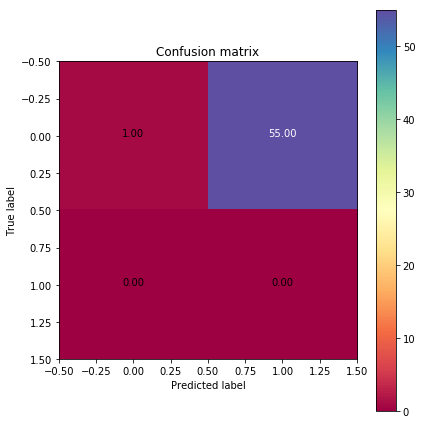

--------------------------------------------------


In [18]:
df_acc = pd.read_csv('data/csv/bhargav/accelerometer-walk.csv', header=None)
df_gyro = pd.read_csv('data/csv/bhargav/gyroscope-walk.csv', header=None)
df_mag = pd.read_csv('data/csv/bhargav/magnetic-walk.csv', header=None)

df_acc = compute_feats(df_acc, show_plots=False)
df_acc.columns = ['acc_' + str(col) for col in df_acc.columns]

df_gyro = compute_feats(df_gyro, show_plots=False)
df_gyro.columns = ['gyr_' + str(col) for col in df_gyro.columns]

df_mag = compute_feats(df_mag, show_plots=False)
df_mag.columns = ['mag_' + str(col) for col in df_mag.columns]
dfs = [df_acc, df_gyro, df_mag]
min_len = min([len(df) for df in dfs])
df = pd.concat([df_acc.loc[:min_len-1, :df_acc.columns[-2]], 
                df_gyro.loc[:min_len-1, :df_gyro.columns[-2]], df_mag.loc[:min_len-1, :]], axis=1)
df.columns = [i if i == len(df.columns)-1 else df.columns[i] for i in range(len(df.columns))]
label_col = len(df.columns) - 1
labels = df[label_col]
labels = labels.astype('int')
data = df.drop(label_col, axis=1)    
use_models = ['RFClassifier-onevsone', 'RFClassifier-onevsrest', 'SVMClassifier-onevsone', 'SVMClassifier-onevsrest']
for use_model in use_models:
    clf = pickle.load(open('models/' + use_model + '.pkl', 'rb'))
    y_pred = clf.predict(data)
    print('-'*50)
    print('USING %s MODEL' %use_model)
    print('Accuracy is:', accuracy_score(labels, y_pred))
    print('Classification Report:\n', classification_report(labels, y_pred,target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(labels, y_pred))
    plot_confusion_matrix(confusion_matrix(labels, y_pred), target_names)
    print('-'*50)

In [ ]:
df[22].value_counts().plot(kind='bar', title='Training examples by activity type')
plt.show()

In [ ]:
def plot_activity(activity, df):
    data = df[df[22] == activity][[1, 2, 3]][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plot_activity(0, df)
plt.show()
plot_activity(1, df)
plt.show()
plot_activity("standing", df)
plt.show()
plot_activity("laying_down", df)
plt.show()